# Similarity profiles

In [1]:
from math import floor, ceil

from itertools import chain

from scipy.spatial.distance import pdist

import seaborn as sns

from local_utils.rdkit_utils import FP

In [2]:
sns.set()

In [3]:
# ChEMBL connection...

engine = create_engine(open('database.txt').read().strip())

## Load actives

Reload the list of the active target/compound combinations of interest.


* Targets are defined in terms of symbol/species pairs.


* Only Human targets are being considered at this stage.


* Only targets with a minimum of 40 actives are considered.


* Active compounds are defined in terms of USMILES.


* See notebook '[10_Get_actives_and_mols](10_Get_actives_and_mols.ipynb)' for further details of the file'`actives.pkl` and the table '`tt_curve_data_actives_subset`'.

In [4]:
# Reload active mols...

actives, active_mols = pickle.load(open('actives.pkl'))

In [5]:
# Load classes for actives...

classes = pd.read_pickle('target_class_map.pkl').merge(actives.groupby('symbol').apply(len).to_frame('N'), left_index=True, right_index=True).sort().reset_index(drop=False)

## Pairwise similarirty of random ChEMBL compounds

In [6]:
df = pd.read_sql_query("""
select distinct
     d.chembl_id as cmpd
   , b.canonical_smiles as smiles
from
       chembl_20.molecule_hierarchy a
  join chembl_20.compound_structures b on a.parent_molregno = b.molregno
  join chembl_20.compound_properties c on a.parent_molregno = c.molregno
  join chembl_20.chembl_id_lookup d on a.parent_molregno = d.entity_id
where
    c.heavy_atoms >= 10
and c.heavy_atoms <= 50
and d.entity_type = 'COMPOUND'
""", engine)

df.shape

(1305372, 2)

In [7]:
n_mols = 10000

tmp = df.iloc[np.random.permutation(df.shape[0])[:n_mols*1.1]].copy() # Take a few extra

def f(x):
    
    mol = Chem.MolFromSmiles(x)
    
    return Chem.MolToSmiles(mol) if mol else None
    
tmp['usmiles'] = tmp['smiles'].apply(f)

tmp = tmp[~tmp['usmiles'].isnull()]

tmp = tmp.groupby('usmiles').apply(lambda x: pd.Series({'cmpds': x['cmpd'].tolist()})).reset_index(drop=False)

tmp.shape

(10996, 2)

In [8]:
mols = tmp.iloc[np.random.permutation(tmp.shape[0])[:n_mols]].copy()

PandasTools.AddMoleculeColumnToFrame(mols, smilesCol='usmiles', molCol='mol')

mols['FP'] = mols['mol'].apply(FP)

mols.shape

(10000, 4)

In [9]:
fps = mols['FP'].apply(lambda x: x.fp).tolist()

x = 1 - pdist(fps, metric='jaccard')

x.sort()

In [10]:
# Value above which only 1% of values lie...

x0 = x[-int(x.size * 1/100)]

round(x0, 2)

0.23

In [11]:
# Percentage over 0.25...

"{:.2f} %".format(100*(x > 0.25).sum()/x.size)

'0.51 %'

In [14]:
# Set threshold at 0.25...

sim_threshold = 0.25

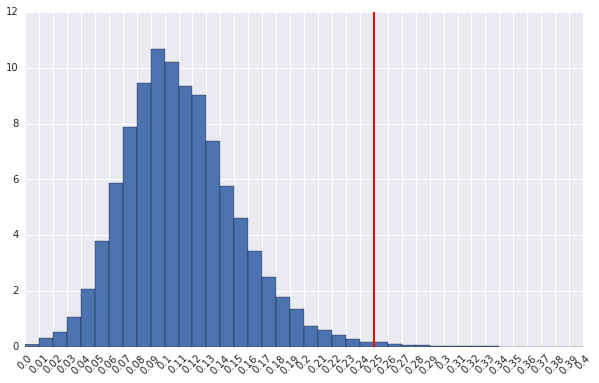

In [15]:
# Plot histogram...

xmin, xmax, bin_size = 0, 0.4, 0.01

bins = np.arange(xmin, xmax + bin_size, bin_size)

fig, axis = plt.subplots()

fig.set_size_inches(10, 6)

axis.hist(x, bins=bins, normed=1, histtype='bar')

axis.set_xlim(xmin, xmax)

axis.set_xticks(bins)

axis.set_xticklabels(bins, rotation=45)

_ = axis.axvline(x=sim_threshold, color='r', linestyle='-', linewidth=2)

## Plot pairwise similarities

In [16]:
actives.head(1)

,symbol,usmiles
symbol,,
ABCB1,ABCB1,C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12


,mol,FP,core_smiles
usmiles,,,
C=CC(C)(C)c1c(O)cc(O)c2c(=O)c(O)c(-c3ccc(OC)cc3)oc12,,"[0 0 0 ..., 0 0 0]",O=c1cc(-c2ccccc2)oc2ccccc12

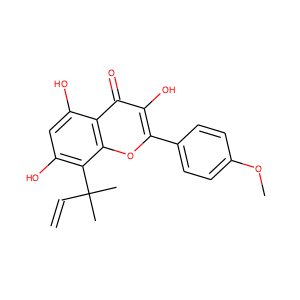

In [17]:
active_mols.head(1)

In [18]:
sample_size = 1000

ncols = 3

xsize, ysize = 6, 4

xmin, xmax, bin_size = 0, 1, 0.05

bins = np.arange(xmin, xmax + bin_size, bin_size)

def do_plots(symbols):
            
    nrows = int(ceil(len(symbols) / ncols))

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols)

    fig.set_size_inches(ncols * xsize, nrows * ysize)
    
    medians = []

    for axis, symbol in zip(axes.flat, symbols):
        
        # Get similarities (sampling to reduce time taken)...
                        
        fps = actives.loc[symbol].merge(active_mols, left_on='usmiles', right_index=True)['FP']

        n_fps = fps.size
        
        sample = fps[np.random.permutation(n_fps)[:min(n_fps, sample_size)]].apply(lambda x: x.fp).tolist()

        x = 1 - pdist(sample, metric='jaccard')
        
        medians.append(np.median(x))
                                                  
        # Plot histogram...

        axis.hist(x, bins=bins, normed=1, histtype='bar')

        axis.set_xlim(xmin, xmax)

        axis.set_xticks(bins)

        axis.set_xticklabels(bins, rotation=45)

        axis.set_title("{} ({})".format(symbol, len(fps)))
        
        axis.axvline(x=sim_threshold, color='r', linestyle='-', linewidth=2)
        
    plt.tight_layout()
    
    for axis in axes.flat[len(symbols):]: axis.set_visible(False) # Hide surplus plots
        
    return pd.DataFrame({'median': medians}, index=symbols)

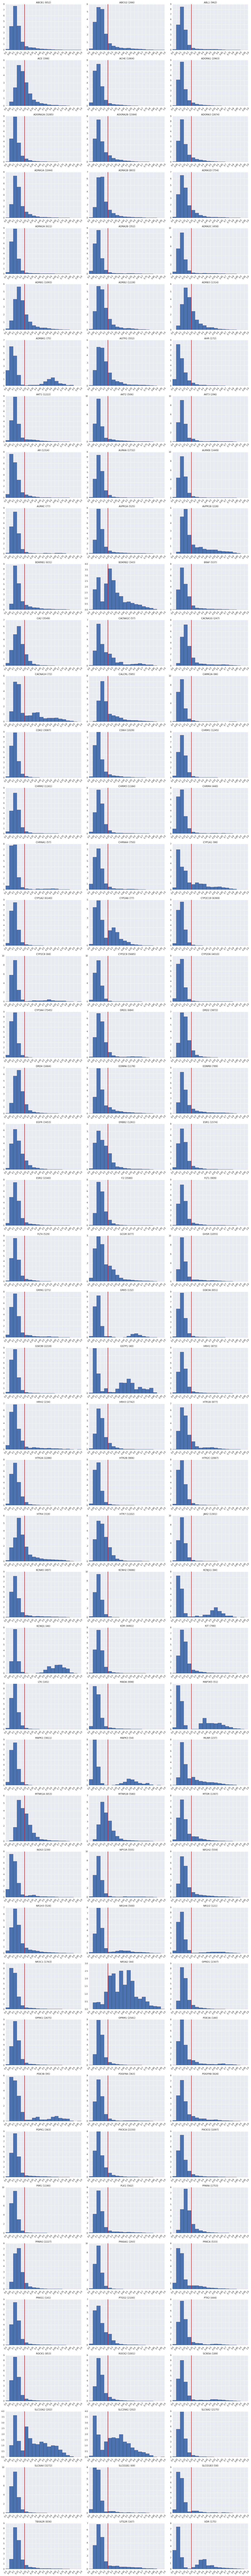

In [19]:
symbols = actives['symbol'].unique()

medians = do_plots(symbols)

In [20]:
medians.sort('median', inplace=True)

In [21]:
# Positions of CYPS...

[medians.index.get_loc(x)+1 for x in ['CYP1A2', 'CYP2C9', 'CYP2C19', 'CYP3A4', 'CYP2D6']]

[16, 24, 14, 11, 10]

## Plots for specific target classes

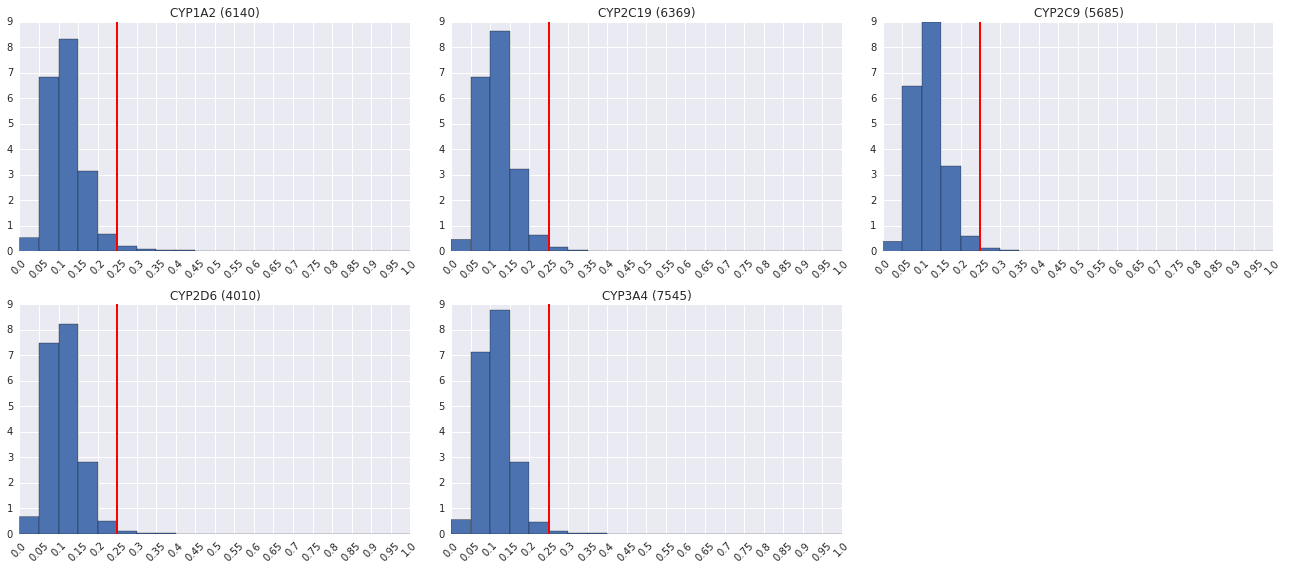

In [22]:
symbols = classes.query("target_class == 'Enzyme > Cytochrome P450' and N > 100")['symbol']

_ = do_plots(symbols)

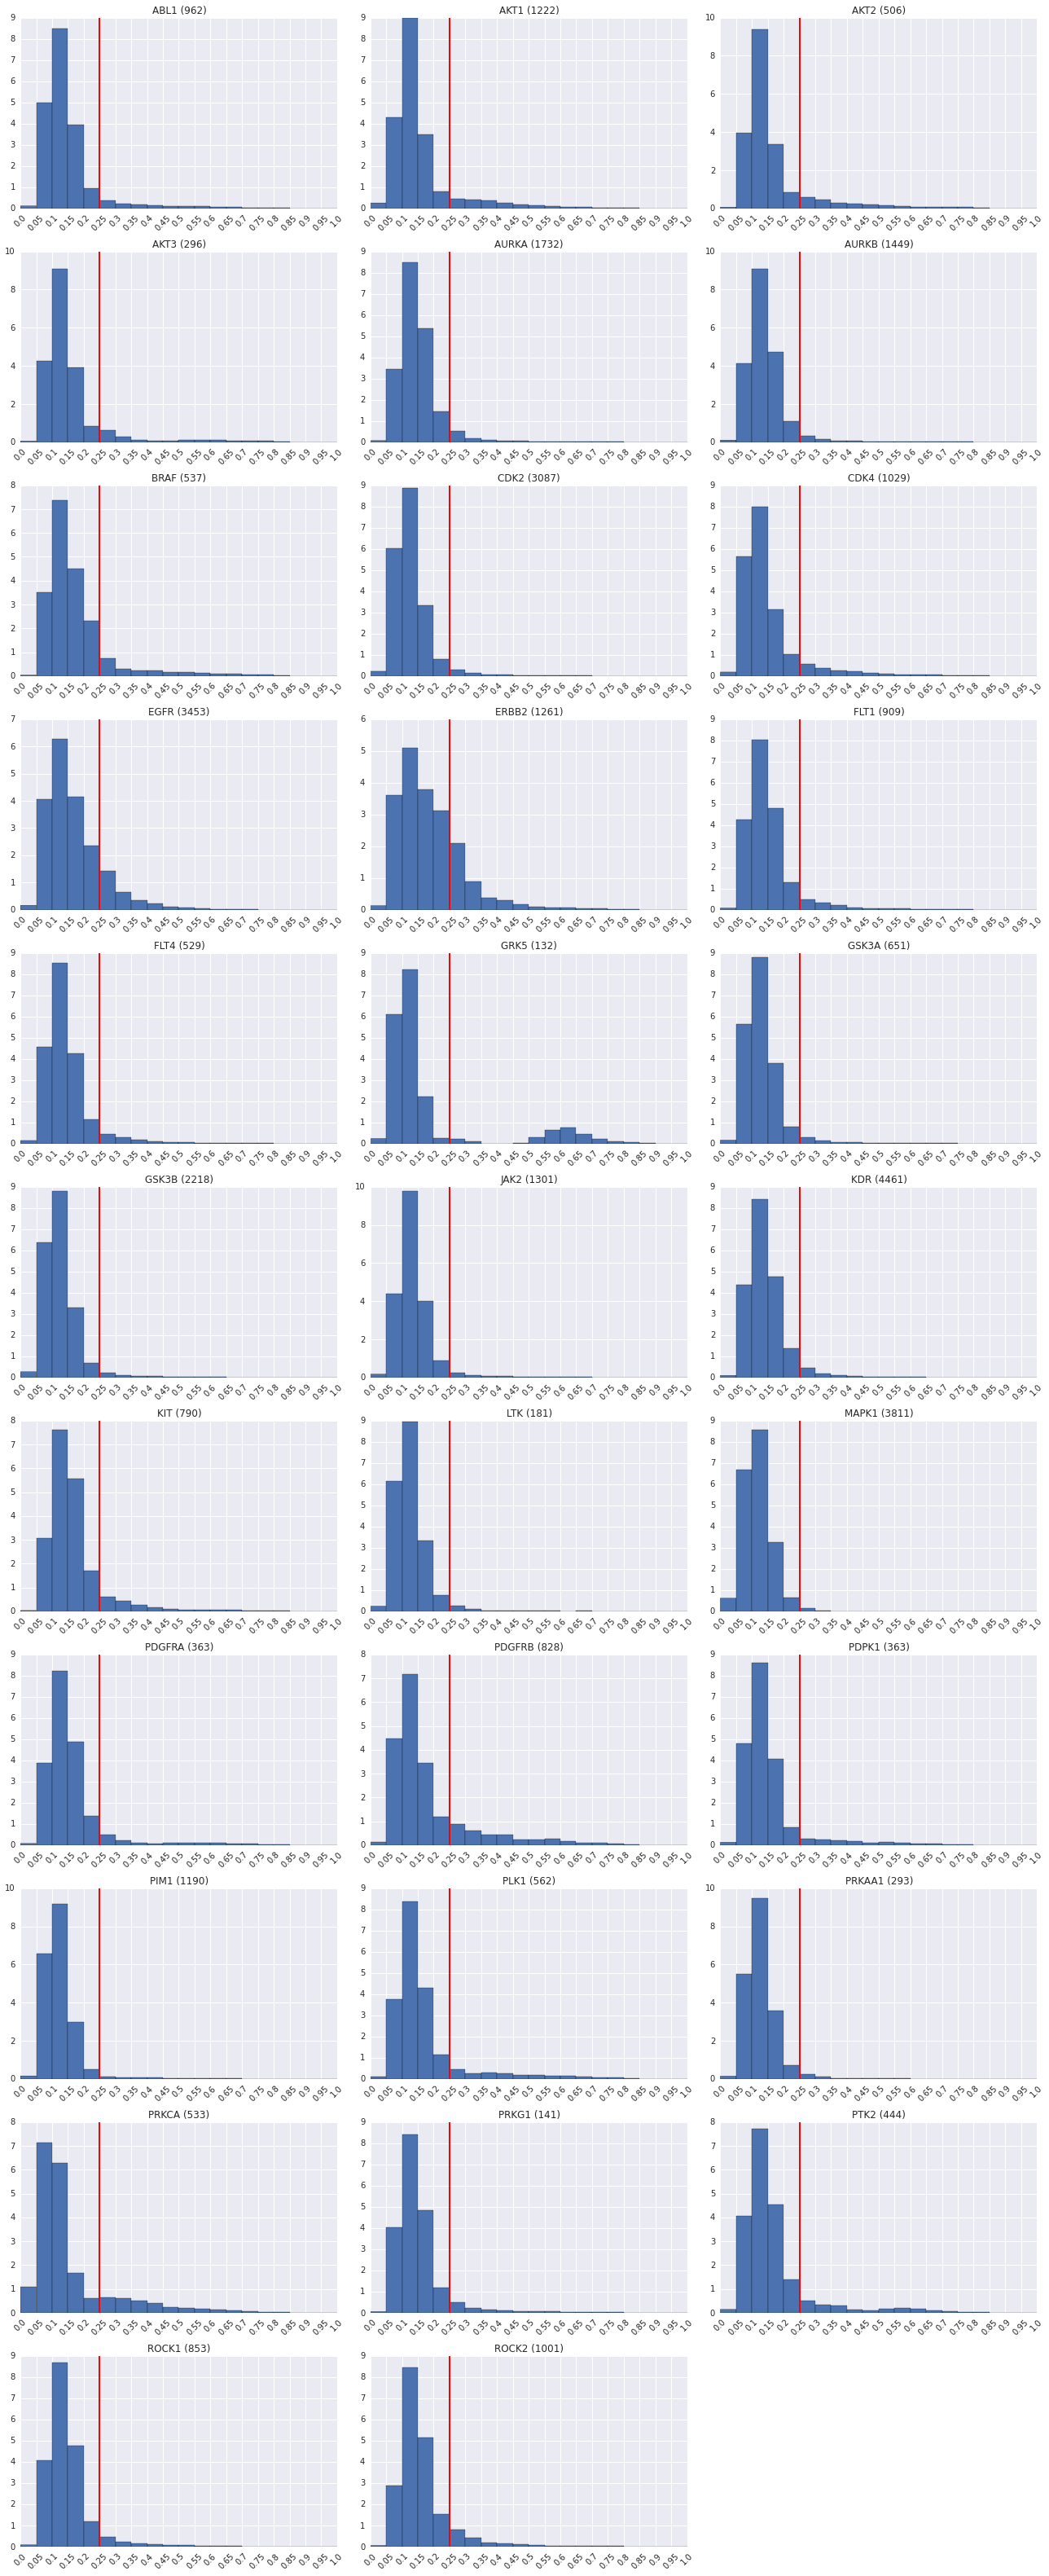

In [23]:
symbols = classes.query("target_class == 'Enzyme > Kinase > Protein Kinase' and N > 100")['symbol']

_ = do_plots(symbols)